# Udacity Data Scientist for Enterprise Nanodegree Capstone project
### Collin Zheng

# Project Overview and Problem Statement

### We aim to build a machine learning model that can predict employee churn from a hypothetical mid-sized company of 10,000+ employees. HR would like to use the trained model for their permanent employees to help prevent talent loss.

**Deliverable**: Executable model script (.pkl). I will also provide a list of features ranked by importance.<br>

**Machine learning task**: Binary classification.<br>

**Target variable**: Status (Employed/Left).<br>

**Metrics**: Primary metric is AUROC, the standard for binary classification problems. The dataset is imbalanced (75/25), however we will use stratified sampling in our solution.

**Datasets**: employee_data.csv. This is a dataset of 14,249 current and past employees at some anonymous company. This dataset was sourced from elitedatascience.com in 2018 when I first started learning about data science.

**Personal motivation**: I work in the banking sector where customer churn is an important concern. Here, I've decided to flip that over and investigate people churn from the perspective of employees! Exciting.

**Strategy**: On a 'first pass', I will explore and clean the dataset before utilising three types of common algorithms for classification: logistic regression (both L1/L2 regularised), random forest and gradient-boosted trees. On a 'second pass', I'll try to improve the model performance by introducing some carefully engineered features based on bivariate segmentations done in the EDA section.

**Data dictionary for original dataset employee_data.csv**:<br>
*Admin info:*
- **department**
- **salary**: categorical and relative to other employees in their department
- **tenure**: number of years at company
- **recently_promoted** (proxy for job performance): period is last 3 years

*Workload info:*
- **n_projects**: number of projects employee is currently working on
- **avg_monthly_hrs**: average monthly hours worked

*Mutual evaluation info:*
- **satisfaction**: higher is better
- **last_evaluation** (proxy for job performance): higher is better
- **filed complaint** (proxy for satisfaction): time period is last 3 years




# Exploratory data analysis

### Import packages and load data:

In [89]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

import seaborn as sb
sb.set_style('darkgrid')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

In [90]:
df = pd.read_csv('employee_data.csv')

### Basic exploration of dataset:

In [91]:
df.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
0,221,engineering,NaN,0.932868,4,NaN,low,0.829896,Left,5.0
1,232,support,NaN,NaN,3,NaN,low,0.834544,Employed,2.0
2,184,sales,NaN,0.788830,3,NaN,medium,0.834988,Employed,3.0
3,206,sales,NaN,0.575688,4,NaN,low,0.424764,Employed,2.0
4,249,sales,NaN,0.845217,3,NaN,low,0.779043,Employed,3.0


In [92]:
df.shape

(14249, 10)

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14249 entries, 0 to 14248
Data columns (total 10 columns):
avg_monthly_hrs      14249 non-null int64
department           13540 non-null object
filed_complaint      2058 non-null float64
last_evaluation      12717 non-null float64
n_projects           14249 non-null int64
recently_promoted    300 non-null float64
salary               14249 non-null object
satisfaction         14068 non-null float64
status               14249 non-null object
tenure               14068 non-null float64
dtypes: float64(5), int64(2), object(3)
memory usage: 1.1+ MB


In [94]:
df.describe()

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure
count,14249.000000,2058.0,12717.000000,14249.000000,300.0,14068.000000,14068.000000
mean,199.795775,1.0,0.718477,3.773809,1.0,0.621295,3.497228
std,50.998714,0.0,0.173062,1.253126,0.0,0.250469,1.460917
min,49.000000,1.0,0.316175,1.000000,1.0,0.040058,2.000000
25%,155.000000,1.0,0.563866,3.000000,1.0,0.450390,3.000000
50%,199.000000,1.0,0.724939,4.000000,1.0,0.652527,3.000000
75%,245.000000,1.0,0.871358,5.000000,1.0,0.824951,4.000000
max,310.000000,1.0,1.000000,7.000000,1.0,1.000000,10.000000


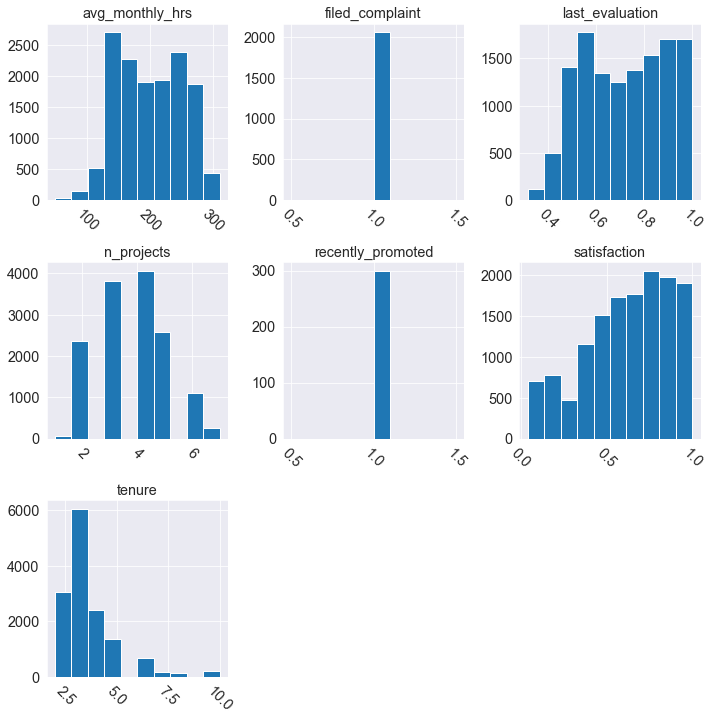

In [98]:
# plot distribution of numerical features
df.hist(figsize=(10,10), xrot=-45)
plt.tight_layout()
plt.show()

In [96]:
df.dtypes

avg_monthly_hrs        int64
department            object
filed_complaint      float64
last_evaluation      float64
n_projects             int64
recently_promoted    float64
salary                object
satisfaction         float64
status                object
tenure               float64
dtype: object

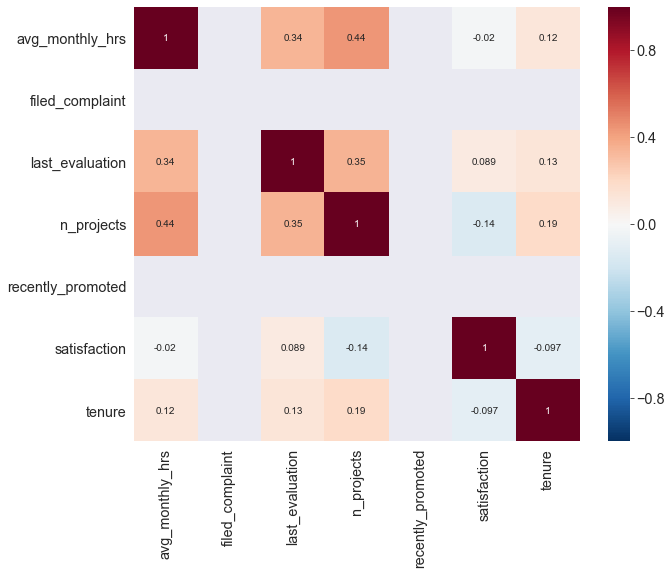

In [97]:
# print correlation heatmap
corr = df.corr()
plt.figure(figsize=(10,8))
sb.heatmap(corr,
          annot=True,
          cmap='RdBu_r',
          vmin=-1,
          vmax=1)
plt.show()

#### Comments: as we'll see later, filed_complaint and recently_promoted have some NaN's. We'll fix these later and reproduce this heatmap. In the meantime, the strongest correlation is between n_projects and avg_monthly_hours. That's not a surprise! Both features can be thought of as proxies for workload.

### Let's check out the stats for just the categorical features:

In [10]:
df.describe(include=['object'])

,department,salary,status
count,13540,14249,14249
unique,12,3,2
top,sales,low,Employed
freq,3923,6952,10857


#### Comment: There are 12 departments, 3 salary classes and 2 classes for our target variable. Note that both department and salary have missing values.
### Bar plots for each of these categorical features:

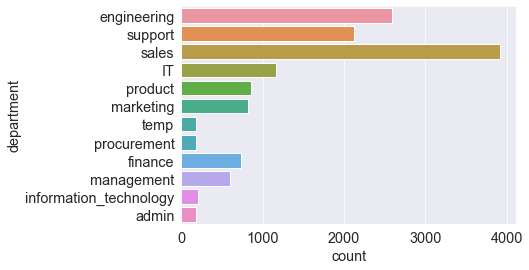

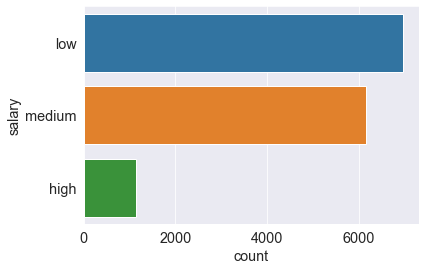

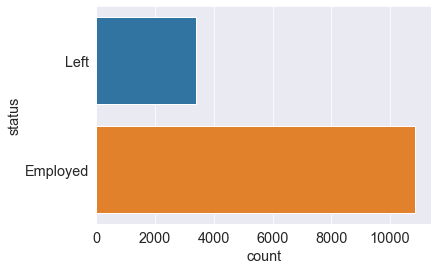

In [11]:
for feature in df.dtypes[df.dtypes=='object'].index:
    sb.countplot(y=feature, data=df)
    plt.show()

#### Comments: Sparse classes? Nah. But there are some employees "temps" who are not permanent employees--they are out of scope for this project and should thus be removed from the analytical base table. Finally, Information Technology and IT are same--these two classes should be merged.

### What's the workload for different departments? Let's group by department and perform some aggregate calculations:

In [12]:
df.groupby('department').mean().sort_values(by='avg_monthly_hrs', ascending=False)

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure
department,,,,,,,
engineering,202.469522,1.0,0.722332,3.872299,1.0,0.617907,3.402392
IT,202.175711,1.0,0.720712,3.806202,1.0,0.628324,3.481481
information_technology,202.167464,1.0,0.716156,3.832536,1.0,0.626717,3.315789
admin,201.272727,1.0,0.726282,3.897727,1.0,0.611450,3.369318
finance,201.175824,1.0,0.723880,3.815934,1.0,0.586787,3.543956
management,201.025210,1.0,0.729714,3.857143,1.0,0.630428,4.294118
support,200.975495,1.0,0.723200,3.804430,1.0,0.626923,3.394910
sales,200.842467,1.0,0.711254,3.772878,1.0,0.623075,3.527148
product,199.991860,1.0,0.719616,3.817442,NaN,0.628774,3.487209


#### Comments: Engineering and IT takes it. Not a surprise!

### Let's now study the target variable "status" in more detail. Our features generally tell us about the: happiness, performance, workload and experience of an employee. We'll first look at some univariate segmentations, before combining those 4 traits in bivariate pairs that will give us ideas for feature engineering.

### Let's do a univariate segmentation of satisfaction (i.e. happiness) by status. The hypothesis here is less satisfied employees might be leaving more often?

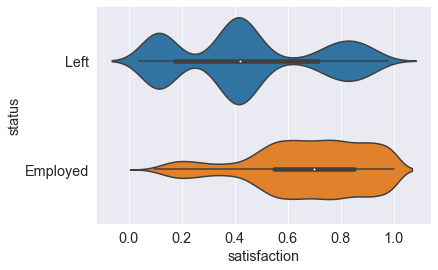

In [13]:
sb.violinplot(y='status', x='satisfaction', data=df)
plt.show()

#### Comments: Those currently employed are largely satisfied with their jobs. Not a surprise. BUT those who have left also include highly satisfied employees! We'll come back to this later.

### Now let's segment last_evaluation (i.e. performance) by status. The hypothesis is that low performance might correlate to leaving?

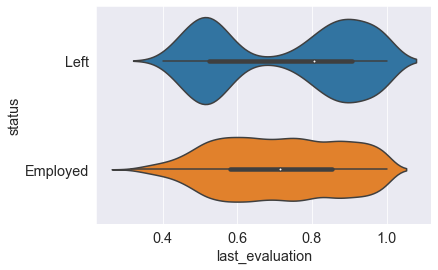

In [14]:
sb.violinplot(y='status', x='last_evaluation', data=df)
plt.show()

#### Comments: those who left had either distinctively bad or GOOD performance. Overachievers and those who felt they had run out of room to grow in the company?

### Now let's do avg_monthly_hrs (i.e. workload) by status. The hypothesis here is those who are overworked might be leaving more.

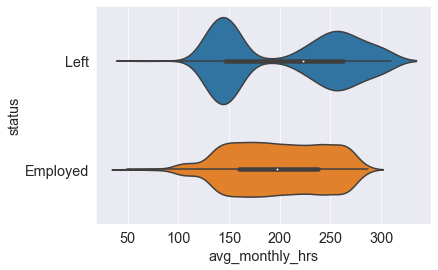

In [15]:
sb.violinplot(y='status', x='avg_monthly_hrs', data=df)
plt.show()

#### Comments: those who have left had either distinctively high or a LOW workload. Interesting.

### Now let's do n_projects (i.e. workload) by status. Since n_projects is also proxy for workload, I'm expecting perhaps similar results to the above plot.

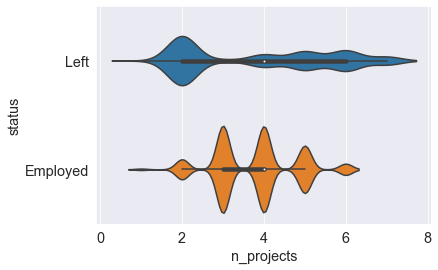

In [16]:
sb.violinplot(y='status', x='n_projects', data=df)
plt.show()

#### Comments: Indeed, it's interesting to see again that a large number of employees with LOW workloads left. Employee disengagement?

### Now let's segment tenure (experience) by status.

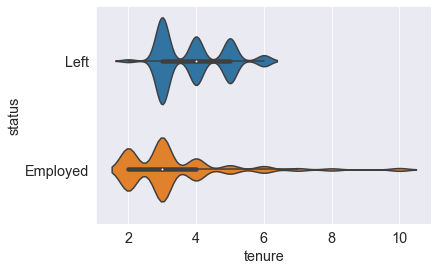

In [17]:
sb.violinplot(y='status', x='tenure', data=df)
plt.show()

#### Those who have left have generally stayed with the company for longer.

### Some interesting insights from these plots include that employees who have left are often: very satisfied, had a low workload or were good performers. Let's do a bivariate segmentations to investigate further.

### Let's do a bivariate segmentation of satisfaction (happiness) and last_evaluation (performance) by status (left or not).

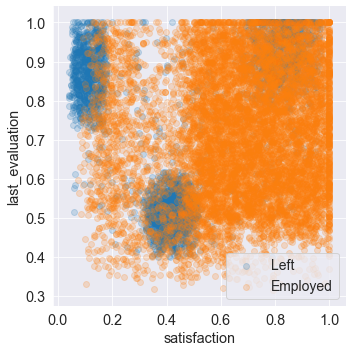

In [18]:
sb.lmplot(x='satisfaction',
          y='last_evaluation',
          hue='status',
          data=df,
          fit_reg=False,
          legend=False,
          scatter_kws={'alpha' : 0.2},
         )

plt.legend(loc='lower right', fontsize=14)
plt.show()

#### Comments: Even with alpha being low, the plot is very messy.

### Let's restrict the plot for just those who have left the company:

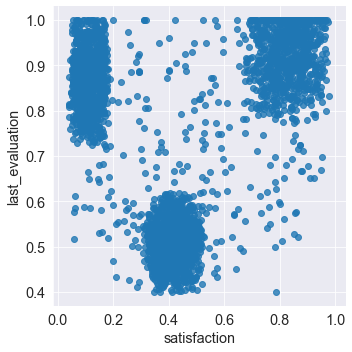

In [19]:
sb.lmplot(x='satisfaction',
          y='last_evaluation',
          data=df[df.status=='Left'],
          fit_reg=False,
          legend=False
         )

plt.show()

#### Comments: we have three distinct clusters: "Underperformers" (low performance), "Unhappy" (low happiness) and "Overachievers" (high both). Keep this in mind for feature engineering.

### Let's now do a bivariate segmentation of last_evaluation (performance) and avg_monthly_hrs (workload) by status (those who have left only):

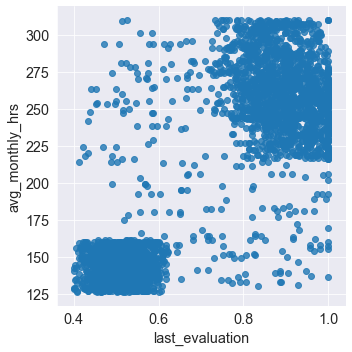

In [20]:
sb.lmplot(x='last_evaluation',
         y='avg_monthly_hrs',
         data=df[df.status=='Left'],
         fit_reg=False)
plt.show()

#### Comments: we have two distinct clusters: "Stars" (high performance and workload) and "Slackers" (low both). Keep this in mind for feature engineering.

### Let's now do a bivariate segmentation of satisfaction (happiness) and avg_monthly_hrs (workload) by status (those who have left only):

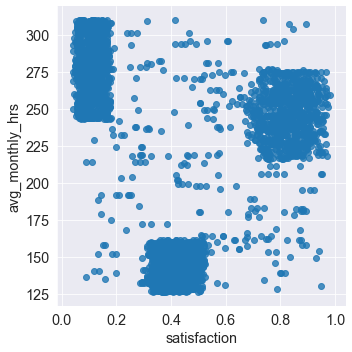

In [21]:
sb.lmplot(x='satisfaction',
          y='avg_monthly_hrs',
          data=df[df.status=='Left'],
          fit_reg=False,
         )
plt.show()

#### Comments: we have three distinct clusters: "Workaholics" (high workload and happiness), "Just-a-job" (Low workload and OK happiness) and "Overworked" (high workload and low happiness).

# Data preprocessing

### Drop duplicates:

In [22]:
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

(14249, 10)
(14221, 10)


### Check for missing values:

In [23]:
df.isnull().sum()

avg_monthly_hrs          0
department             709
filed_complaint      12165
last_evaluation       1504
n_projects               0
recently_promoted    13921
salary                   0
satisfaction           153
status                   0
tenure                 153
dtype: int64

#### Comments: 6 features--department, filed_complaint, last_evaluation, recently_promoted, satisfaction and tenure--have missing values.

### The features filed_complaint and recently_promoted are binary features whose NaN's mean 0. Let's clean these:

In [24]:
df.filed_complaint.unique()

array([nan,  1.])

In [25]:
df.filed_complaint.fillna(0, inplace=True)

In [26]:
df.filed_complaint.unique()

array([0., 1.])

In [27]:
df.recently_promoted.fillna(0, inplace=True)

In [28]:
df.recently_promoted.unique()

array([0., 1.])

In [29]:
df.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
0,221,engineering,0.0,0.932868,4,0.0,low,0.829896,Left,5.0
1,232,support,0.0,NaN,3,0.0,low,0.834544,Employed,2.0
2,184,sales,0.0,0.788830,3,0.0,medium,0.834988,Employed,3.0
3,206,sales,0.0,0.575688,4,0.0,low,0.424764,Employed,2.0
4,249,sales,0.0,0.845217,3,0.0,low,0.779043,Employed,3.0


### Re-checking our missing values:

In [30]:
df.isnull().sum()

avg_monthly_hrs         0
department            709
filed_complaint         0
last_evaluation      1504
n_projects              0
recently_promoted       0
salary                  0
satisfaction          153
status                  0
tenure                153
dtype: int64

#### Comments: now we just have four features with missing values. There's no easy fix for these, so we'll leave it for now.

### Since salary is an ordinal feature, let's encode them into numerical classes for our algorithms:

In [31]:
df['salary_numeric'] = df.salary.replace({'low':0, 'medium':1, 'high':2})

In [32]:
df.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure,salary_numeric
0,221,engineering,0.0,0.932868,4,0.0,low,0.829896,Left,5.0,0
1,232,support,0.0,NaN,3,0.0,low,0.834544,Employed,2.0,0
2,184,sales,0.0,0.788830,3,0.0,medium,0.834988,Employed,3.0,1
3,206,sales,0.0,0.575688,4,0.0,low,0.424764,Employed,2.0,0
4,249,sales,0.0,0.845217,3,0.0,low,0.779043,Employed,3.0,0


### We now have 8 numerical features. Let's do a correlation heatmap:

In [33]:
corr = df.corr()

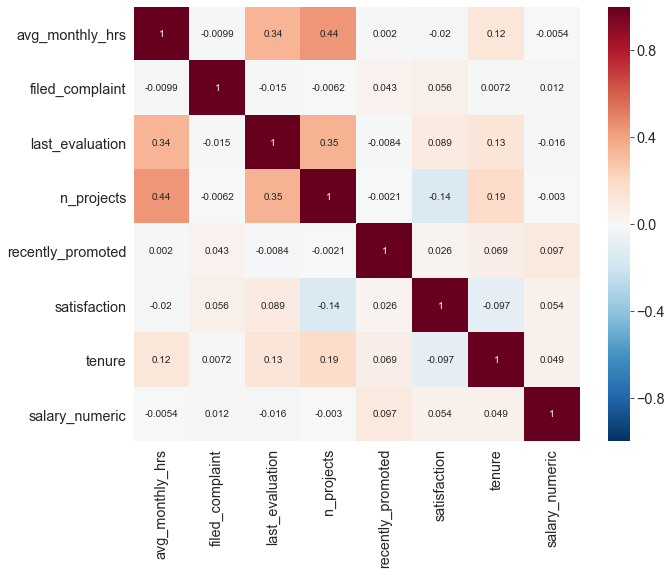

In [87]:
plt.figure(figsize=(10,8))
sb.heatmap(corr,
          annot=True,
          cmap='RdBu_r',
          vmin=-1,
          vmax=1)
plt.show()

### With the heatmap plotted, let's get rid of salary_numeric as we'll later hot-encode the feature using pandas get_dummies:

In [35]:
df.drop('salary_numeric', axis=1, inplace=True)
df.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
0,221,engineering,0.0,0.932868,4,0.0,low,0.829896,Left,5.0
1,232,support,0.0,NaN,3,0.0,low,0.834544,Employed,2.0
2,184,sales,0.0,0.788830,3,0.0,medium,0.834988,Employed,3.0
3,206,sales,0.0,0.575688,4,0.0,low,0.424764,Employed,2.0
4,249,sales,0.0,0.845217,3,0.0,low,0.779043,Employed,3.0


### Data cleaning--let's combine the information_technology and IT classes in department feature:

In [36]:
df.department.replace('information_technology', 'IT', inplace=True)

### Data cleaning--let's remove the "temp" class from department as that's out of scope for the project. HR is only interested in using the model for permanent employees.

In [37]:
df = df[df.department != 'temp']

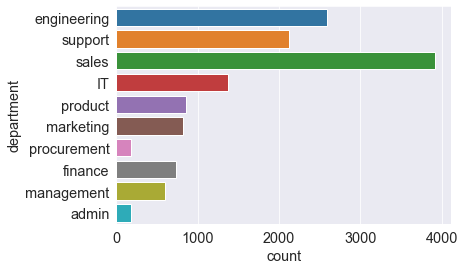

In [38]:
sb.countplot(y='department', data=df)
plt.show()

### Re-checking our missing values:

In [39]:
df.isnull().sum()

avg_monthly_hrs         0
department            709
filed_complaint         0
last_evaluation      1351
n_projects              0
recently_promoted       0
salary                  0
satisfaction            0
status                  0
tenure                  0
dtype: int64

#### Comments: satisfaction and tenure no longer have missing figures! They must have all belonged to the "temp" workers.

### We still have two features with missing values. Department is categorical, so let's label these values as its own Missing class for the algorithms.

In [40]:
df['department'].fillna('Missing', inplace=True)

In [41]:
df.department.value_counts()

sales          3923
engineering    2592
support        2122
IT             1370
product         860
marketing       819
finance         728
Missing         709
management      595
admin           176
procurement     174
Name: department, dtype: int64

In [42]:
df.isnull().sum()

avg_monthly_hrs         0
department              0
filed_complaint         0
last_evaluation      1351
n_projects              0
recently_promoted       0
salary                  0
satisfaction            0
status                  0
tenure                  0
dtype: int64

### For last_evaluation, rather than interpolate we'll make an indicator variable to indicate missingness:

In [43]:
df['last_evaluation_missing'] = df.last_evaluation.isnull().astype(int)

In [44]:
df.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure,last_evaluation_missing
0,221,engineering,0.0,0.932868,4,0.0,low,0.829896,Left,5.0,0
1,232,support,0.0,NaN,3,0.0,low,0.834544,Employed,2.0,1
2,184,sales,0.0,0.788830,3,0.0,medium,0.834988,Employed,3.0,0
3,206,sales,0.0,0.575688,4,0.0,low,0.424764,Employed,2.0,0
4,249,sales,0.0,0.845217,3,0.0,low,0.779043,Employed,3.0,0


### Now replace the NaN's with 0 so algorithms will run properly:

In [45]:
df.last_evaluation.fillna(0, inplace=True)

In [46]:
df.isnull().sum()

avg_monthly_hrs            0
department                 0
filed_complaint            0
last_evaluation            0
n_projects                 0
recently_promoted          0
salary                     0
satisfaction               0
status                     0
tenure                     0
last_evaluation_missing    0
dtype: int64

### Convert status into a dummy variable for the algorithms:

In [47]:
df['status'] = pd.get_dummies(df.status).Left

In [48]:
df.status.mean()

0.23933750355416547

### Create dummy variables for the other two categorical variables: department and salary:

In [49]:
df = pd.get_dummies(df, columns=['department', 'salary'])

### Take a look at our analytical_base_table ready for modelling:

In [50]:
df.head(10)

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,status,tenure,last_evaluation_missing,department_IT,department_Missing,department_admin,department_engineering,department_finance,department_management,department_marketing,department_procurement,department_product,department_sales,department_support,salary_high,salary_low,salary_medium
0,221,0.0,0.932868,4,0.0,0.829896,1,5.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,232,0.0,0.000000,3,0.0,0.834544,0,2.0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,184,0.0,0.788830,3,0.0,0.834988,0,3.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,206,0.0,0.575688,4,0.0,0.424764,0,2.0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,249,0.0,0.845217,3,0.0,0.779043,0,3.0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
5,140,0.0,0.589097,4,0.0,0.660020,0,4.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
6,121,1.0,0.625399,3,0.0,0.835571,0,3.0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
7,150,0.0,0.644586,4,0.0,0.796683,0,3.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
8,215,1.0,0.524114,3,0.0,0.715005,0,7.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
9,269,0.0,0.909364,5,0.0,0.994037,0,2.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


### Save our analytical base table (1st version):

In [51]:
df.to_csv('analytical_base_table_v1.csv', index=None)

### Note: we haven't yet engineered the 8 features motivated by our bivariate segmentations, i.e.:
#### - Underperformers
#### - Unhappy
#### - Overachievers
#### - Stars
#### - Slackers
#### - Workaholics
#### - Just-a-job
#### - Overworked
### ...because I'm interested to see how the model performs with the native features. We'll then build a second run of the model that also includes these new features to see how much extra performance we could squeeze out.

# Modelling

### Read in the analytical base table:

In [52]:
df = pd.read_csv('analytical_base_table_v1.csv')

In [53]:
y = df.status
X = df.drop('status', axis=1)

### Split into train and test using stratified sampling to ensure the target variable's classes are balanced:

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=df.status)

In [55]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

11254 2814 11254 2814


### Create pipeline dictionary for four algorithms: L1-regularised & L2-regularised logistic regression, random forest, gradient boosted tree:

In [56]:
pipelines = {
    'l1' : make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', random_state=123)),
    'l2' : make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', random_state=123)),
    'rf' : make_pipeline(RandomForestClassifier(random_state=123)),
    'gb' : make_pipeline(GradientBoostingClassifier(random_state=123))
}

### Declare hyperparameter grids and create a hyperparameters dictionary:

#### For logistic regression, the most impactful hyperparameter is the strength of the penalty, C.

In [57]:
l1_hyperparameters = {
    'logisticregression__C' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
}

l2_hyperparameters = {
    'logisticregression__C' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
}

#### For random forest, we'll tune n_estimators, max_features and min_samples_leaf.

In [58]:
rf_hyperparameters = {
    'randomforestclassifier__n_estimators' : [100, 200],
    'randomforestclassifier__max_features' : ['auto', 'sqrt', 0.33],
    'randomforestclassifier__min_samples_leaf' : [1, 3, 5, 10],
}

#### For gradient boosted tree, we'll tune n_estimators, learning_rate and max_depth.

In [59]:
gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators' : [100, 200],
    'gradientboostingclassifier__learning_rate' : [0.05, 0.1, 0.2],
    'gradientboostingclassifier__max_depth' : [1, 3, 5]
}

### Create hyperparameters dictionary:

In [60]:
hyperparameters = {
    'l1' : l1_hyperparameters,
    'l2' : l2_hyperparameters,
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters
}

### Fit and tune models with cross-validation:

In [61]:
fitted_models = {}

# loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    
    print("Currently fitting:", name)
    
    # create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # fit model and store it in fitted_models disctionary
    model.fit(X_train, y_train)
    fitted_models[name] = model
    
    print("Fitting for", name, "completed.")


Currently fitting: l1
Fitting for l1 completed.
Currently fitting: l2
Fitting for l2 completed.
Currently fitting: rf
Fitting for rf completed.
Currently fitting: gb
Fitting for gb completed.


# Results

### First print out the cross-validated performance on the training set (holdout accuracy scores) for each algorithm:

In [62]:
for name, model in fitted_models.items():
    print(name, model.best_score_)

l1 0.7808779100764173
l2 0.7808779100764173
rf 0.9805402523547183
gb 0.9748533854629465


### Now, for each algorithm, obtain confusion matrix and display ROC curve and print AUROC scores:

Results for: l1 

[[1997  144]
 [ 429  244]]

AUROC: 0.8461391650872064


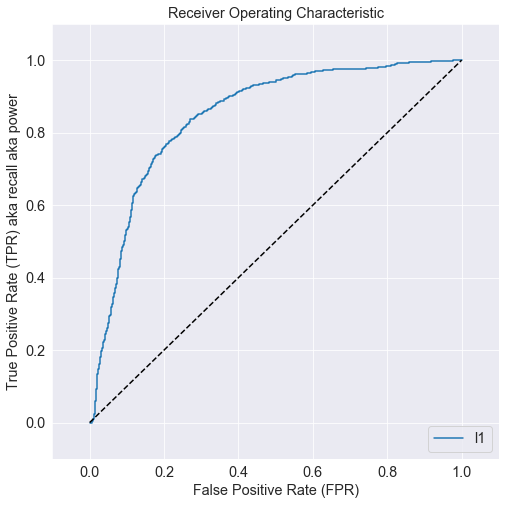



Results for: l2 

[[1998  143]
 [ 429  244]]

AUROC: 0.8461141805810702


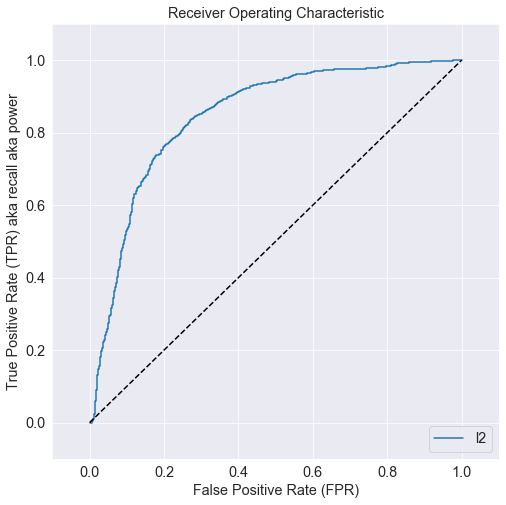



Results for: rf 

[[2132    9]
 [  47  626]]

AUROC: 0.9919751154318883


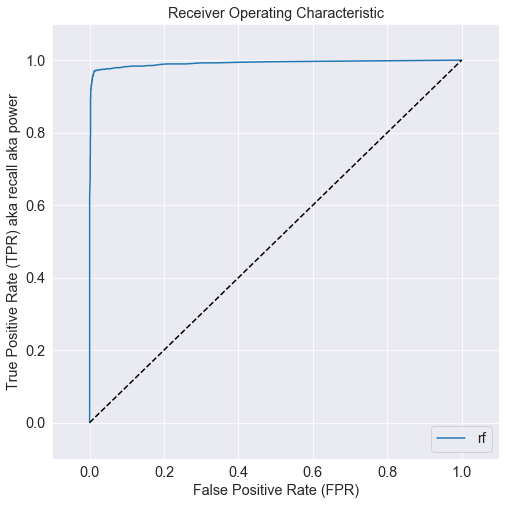



Results for: gb 

[[2115   26]
 [  43  630]]

AUROC: 0.9881316655712812


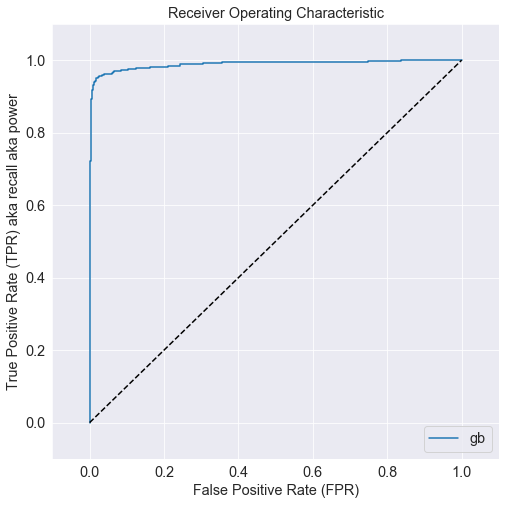

In [63]:
for name, model in fitted_models.items():
    print("Results for:", name, "\n")
    
    # get predictions and print confusion matrix
    pred = fitted_models[name].predict(X_test)
    print(confusion_matrix(y_test, pred))
    
    # get probabilities of predictions (positive class only) and display ROC curve
    pred = fitted_models[name].predict_proba(X_test)
    pred = [p[1] for p in pred]
    
    # print AUROC score
    print("\nAUROC:", roc_auc_score(y_test, pred))
    
    fpr, tpr, thresholds = roc_curve(y_test, pred) # obtain False Positive Rates, True Positive Rates and thresholds
    fig = plt.figure(figsize=(8,8))
    plt.title("Receiver Operating Characteristic")
    plt.plot(fpr, tpr, label=name) # ROC curve
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'k--') # diagonal line
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.ylabel('True Positive Rate (TPR) aka recall aka power')
    plt.xlabel('False Positive Rate (FPR)')
    plt.show()
    
    print("\n")


### Results:
### The random forest and gradient boosted tree performed VERY well, with AUROC around 99%. 
### The very best result came from the rf. 
### The logistic regressions scored lower, at around 85%.

### Save final model as a .pkl file:

In [64]:
with open('model_v1.pkl', 'wb') as f:
    pickle.dump(fitted_models['rf'].best_estimator_, f)

# Improvements to the model through extra feature engineering

### Let's engineer some new features motivated by our EDA segmentations and see how much of a performance boost we can get.

### First, let's reload our old analytical_base_table:

In [65]:
df = pd.read_csv('analytical_base_table_v1.csv')

In [66]:
df.head()

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,status,tenure,last_evaluation_missing,department_IT,department_Missing,department_admin,department_engineering,department_finance,department_management,department_marketing,department_procurement,department_product,department_sales,department_support,salary_high,salary_low,salary_medium
0,221,0.0,0.932868,4,0.0,0.829896,1,5.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,232,0.0,0.000000,3,0.0,0.834544,0,2.0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,184,0.0,0.788830,3,0.0,0.834988,0,3.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,206,0.0,0.575688,4,0.0,0.424764,0,2.0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,249,0.0,0.845217,3,0.0,0.779043,0,3.0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


### From our happiness & performance segmentation:

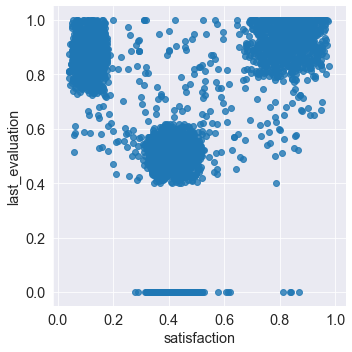

In [67]:
sb.lmplot(x='satisfaction',
         y='last_evaluation',
         data=df[df.status==1],
         fit_reg=False)
plt.show()

#### Comments: There are some 0's for last_evalauation which came from the data cleaning steps. Note that we are not including them in the modelling via. the df.last_evaluation_missing==0" condition.

### We define new features: "Underperformers", "Unhappy" & "Overachievers" by the following logic:
### - Underperformers: for last_evaluation < 0.6
### - Unhappy: satisfaction_level < 0.2 (maybe these employees were overqualified and bored?)
### - Overachievers: last_evaluation > 0.8 and satisfaction > 0.7

In [68]:
df['underperformer'] = ((df.last_evaluation < 0.6) & (df.last_evaluation_missing==0)).astype(int)
df['unhappy'] = (df.satisfaction < 0.2).astype(int)
df['overachiever'] = ((df.last_evaluation > 0.8) & (df.satisfaction > 0.7)).astype(int)

In [69]:
df[['underperformer', 'unhappy', 'overachiever']].mean()

underperformer    0.285257
unhappy           0.092195
overachiever      0.177069
dtype: float64

### From our performance and workload segmentation:

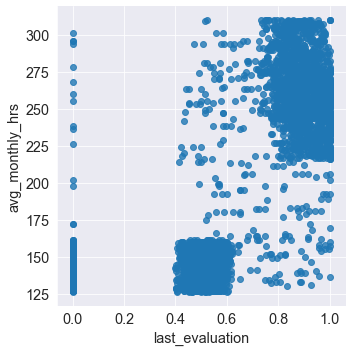

In [70]:
sb.lmplot(x='last_evaluation',
         y='avg_monthly_hrs',
         data=df[df.status==1],
         fit_reg=False)
plt.show()

#### Comments: Similar to above, the last_evaluation==0 data came from data cleaning and will not be included in the modelling.

### We define new features: "Stars" & "Slackers" by the following logic:
### - Stars: avg_monthly_hrs > 215 and last_evaluation > 0.75
### - Slackers: avg_monthly_hrs < 165 and last_evaluation < 0.65

In [71]:
df['stars'] = ((df.avg_monthly_hrs > 215) & (df.last_evaluation > 0.75)).astype(int)
df['slackers'] = ((df.avg_monthly_hrs < 165) & (df.last_evaluation < 0.65) & (df.last_evaluation_missing==0)).astype(int)

In [72]:
df[['stars', 'slackers']].mean()

stars       0.241825
slackers    0.167686
dtype: float64

### Finally, from our happiness vs workload segmentation:

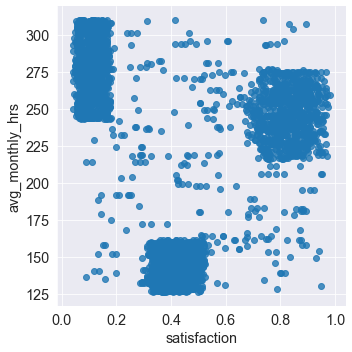

In [73]:
sb.lmplot(x='satisfaction',
          y='avg_monthly_hrs',
          data=df[df.status==1],
          fit_reg=False,
         )
plt.show()

### We define new features: "Workaholics", "Just-a-job" and "Overworked" by the following logic:
### - Workaholics: avg_monthly_hrs > 210 and satisfation > 0.7
### - Just-a-job: avg_monthly_hrs < 170
### - Overworked: avg_monthly_hrs > 225 and satisfaction < 0.2

In [74]:
df['workaholic'] = ((df.avg_monthly_hrs > 210) & (df.satisfaction > 0.7)).astype(int)
df['justajob'] = (df.avg_monthly_hrs < 170).astype(int)
df['overworked'] = ((df.avg_monthly_hrs > 225) & (df.satisfaction < 0.2)).astype(int)

In [75]:
df[['workaholic', 'justajob', 'overworked']].mean()

workaholic    0.226685
justajob      0.339281
overworked    0.071581
dtype: float64

### Take a look at our analytical_base_table ready for modelling:

In [76]:
df.head(10)

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,status,tenure,last_evaluation_missing,department_IT,department_Missing,department_admin,department_engineering,department_finance,department_management,department_marketing,department_procurement,department_product,department_sales,department_support,salary_high,salary_low,salary_medium,underperformer,unhappy,overachiever,stars,slackers,workaholic,justajob,overworked
0,221,0.0,0.932868,4,0.0,0.829896,1,5.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0
1,232,0.0,0.000000,3,0.0,0.834544,0,2.0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
2,184,0.0,0.788830,3,0.0,0.834988,0,3.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
3,206,0.0,0.575688,4,0.0,0.424764,0,2.0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0
4,249,0.0,0.845217,3,0.0,0.779043,0,3.0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0
5,140,0.0,0.589097,4,0.0,0.660020,0,4.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,1,0
6,121,1.0,0.625399,3,0.0,0.835571,0,3.0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0
7,150,0.0,0.644586,4,0.0,0.796683,0,3.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
8,215,1.0,0.524114,3,0.0,0.715005,0,7.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0
9,269,0.0,0.909364,5,0.0,0.994037,0,2.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,0


### Save our analytical base table (2nd version, which includes the 8 new engineered features):

In [77]:
df.to_csv('analytical_base_table_v2.csv', index=None)

### Hyperparameter tuning and model training with new features included:

In [78]:
# split data into train and test
y = df.status
X = df.drop('status', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=df.status)

# pipelines and hyperparameters
pipelines = {
    'l1' : make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', random_state=123)),
    'l2' : make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', random_state=123)),
    'rf' : make_pipeline(RandomForestClassifier(random_state=123)),
    'gb' : make_pipeline(GradientBoostingClassifier(random_state=123))
}

l1_hyperparameters = {
    'logisticregression__C' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
}

l2_hyperparameters = {
    'logisticregression__C' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
}

rf_hyperparameters = {
    'randomforestclassifier__n_estimators' : [100, 200],
    'randomforestclassifier__max_features' : ['auto', 'sqrt', 0.33],
    'randomforestclassifier__min_samples_leaf' : [1, 3, 5, 10],
}

gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators' : [100, 200],
    'gradientboostingclassifier__learning_rate' : [0.05, 0.1, 0.2],
    'gradientboostingclassifier__max_depth' : [1, 3, 5]
}

hyperparameters = {
    'l1' : l1_hyperparameters,
    'l2' : l2_hyperparameters,
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters
}

fitted_models = {}

# loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    
    print("Currently fitting:", name)
    
    # create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # fit model and store it in fitted_models disctionary
    model.fit(X_train, y_train)
    fitted_models[name] = model
    
    print("Fitting for", name, "completed.")

Currently fitting: l1
Fitting for l1 completed.
Currently fitting: l2
Fitting for l2 completed.
Currently fitting: rf
Fitting for rf completed.
Currently fitting: gb
Fitting for gb completed.


### Print results of model with new features included:

In [79]:
# print cross-validation accuracy scores:
for name, model in fitted_models.items():
    print(name, model.best_score_)

l1 0.9088324151412831
l2 0.9088324151412831
rf 0.9793851075173272
gb 0.975475386529234


Results for: l1 

[[2015  126]
 [ 111  562]]

AUROC: 0.9423905869485105


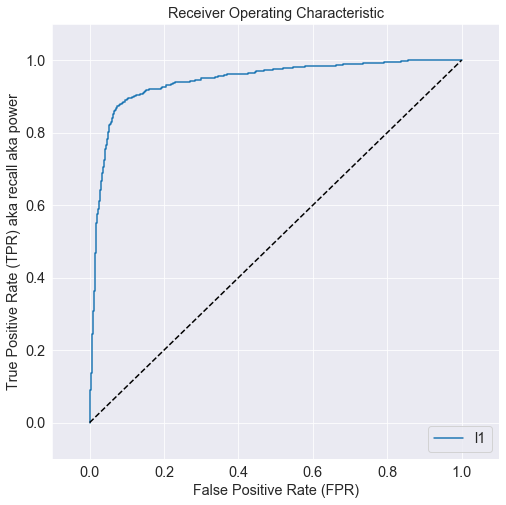



Results for: l2 

[[2014  127]
 [ 110  563]]

AUROC: 0.9423246556128734


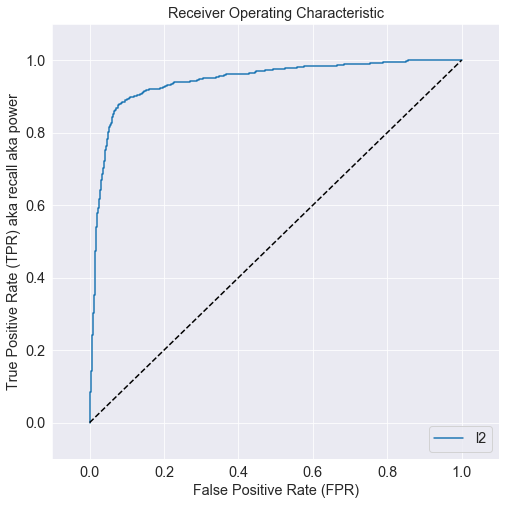



Results for: rf 

[[2129   12]
 [  45  628]]

AUROC: 0.9916117990718256


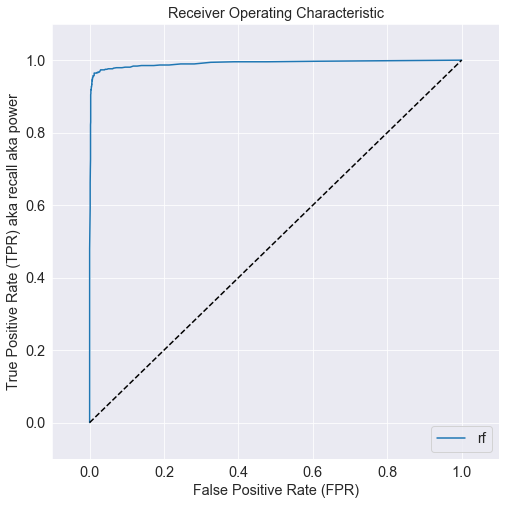



Results for: gb 

[[2120   21]
 [  48  625]]

AUROC: 0.9883547910913578


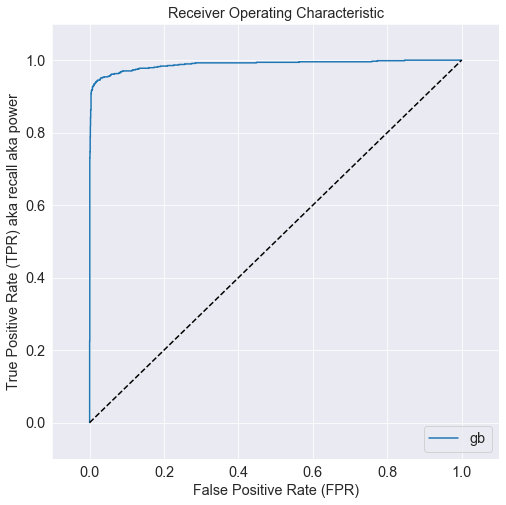

In [80]:
# confusion matrix, AUROC score and ROC curve

for name, model in fitted_models.items():
    print("Results for:", name, "\n")
    
    # get predictions and print confusion matrix
    pred = fitted_models[name].predict(X_test)
    print(confusion_matrix(y_test, pred))
    
    # get probabilities of predictions (positive class only) and display ROC curve
    pred = fitted_models[name].predict_proba(X_test)
    pred = [p[1] for p in pred]
    
    # print AUROC score
    print("\nAUROC:", roc_auc_score(y_test, pred))
    
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    fig = plt.figure(figsize=(8,8))
    plt.title("Receiver Operating Characteristic")
    plt.plot(fpr, tpr, label=name) # ROC curve
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'k--') # diagonal line
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.ylabel('True Positive Rate (TPR) aka recall aka power')
    plt.xlabel('False Positive Rate (FPR)')
    plt.show()
    
    print("\n")



### Updated results:
### The random forest and gradient-boosted trees already performed very well and their AUROC scores did not change by much. 
### The best score still came from the gb, however it is now a smidge LOWER than before (99.19% -> 99.16%)! It appears the inclusion of the new engineered features might have caused a tiny tiny amount of overtraining (tiny tiny increase in model complexity), resulting in a model that did not generalise as well as the simpler model. But the scores are so close that for all intents and purposes both rf's perform just as well.
### The inclusion of the new features lifted the performance of the logistic regressions from 85% to 94%!

### Let us also print out the feature importances for the winning rf algorithm.

In [81]:
# recreate the winning model as a sanity check
print(fitted_models['rf'].best_estimator_)

model = RandomForestClassifier(
    max_depth=None,
    max_features=0.33, 
    max_leaf_nodes=None, 
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0,
    n_estimators=200, 
    random_state=123)
model.fit(X_train, y_train)
print(model)

# validate AUROC
pred = model.predict_proba(X_test)
pred = [p[1] for p in pred]
print("\nAUROC:", roc_auc_score(y_test, pred))

Pipeline(memory=None,
         steps=[('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=0.33, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=200, n_jobs=None,
                                        oob_score=False, random_state=123,
                                        verbose=0, warm_start=False))],
         verbose=False)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.33, max_leaf_nodes=None,
                       min

In [104]:
# take quick look at importances of features in order as they appear in analytical base table v2
importances = model.feature_importances_
importances

array([0.0918275 , 0.0042541 , 0.0636301 , 0.20100442, 0.00098319,
       0.17881048, 0.1694536 , 0.00508433, 0.00162758, 0.00116753,
       0.00056803, 0.00342936, 0.00138866, 0.00123878, 0.00101083,
       0.00029584, 0.00085087, 0.00315773, 0.00265548, 0.00359628,
       0.00437205, 0.00312245, 0.00601547, 0.01648615, 0.02724445,
       0.07437336, 0.02826087, 0.01892541, 0.01683115, 0.06833396])

In [105]:
# create dictionary between indices and column names
dicts = {}
keys = range(30)
values = [name for name in X_train.columns]

for i in keys:
    for x in values:
        dicts[i] = values[i]
print(dicts)

{0: 'avg_monthly_hrs', 1: 'filed_complaint', 2: 'last_evaluation', 3: 'n_projects', 4: 'recently_promoted', 5: 'satisfaction', 6: 'tenure', 7: 'last_evaluation_missing', 8: 'department_IT', 9: 'department_Missing', 10: 'department_admin', 11: 'department_engineering', 12: 'department_finance', 13: 'department_management', 14: 'department_marketing', 15: 'department_procurement', 16: 'department_product', 17: 'department_sales', 18: 'department_support', 19: 'salary_high', 20: 'salary_low', 21: 'salary_medium', 22: 'underperformer', 23: 'unhappy', 24: 'overachiever', 25: 'stars', 26: 'slackers', 27: 'workaholic', 28: 'justajob', 29: 'overworked'}


In [106]:
# sort features according to importance and replace index with feature name
indices = np.argsort(model.feature_importances_)[::-1]
sorted_feature_importance = [dicts[i] for i in indices]
sorted_feature_importance

['n_projects',
 'satisfaction',
 'tenure',
 'avg_monthly_hrs',
 'stars',
 'overworked',
 'last_evaluation',
 'slackers',
 'overachiever',
 'workaholic',
 'justajob',
 'unhappy',
 'underperformer',
 'last_evaluation_missing',
 'salary_low',
 'filed_complaint',
 'salary_high',
 'department_engineering',
 'department_sales',
 'salary_medium',
 'department_support',
 'department_IT',
 'department_finance',
 'department_management',
 'department_Missing',
 'department_marketing',
 'recently_promoted',
 'department_product',
 'department_admin',
 'department_procurement']

Ranking of feature importance:
1. n_projects (0.201004)
2. satisfaction (0.178810)
3. tenure (0.169454)
4. avg_monthly_hrs (0.091827)
5. stars (0.074373)
6. overworked (0.068334)
7. last_evaluation (0.063630)
8. slackers (0.028261)
9. overachiever (0.027244)
10. workaholic (0.018925)
11. justajob (0.016831)
12. unhappy (0.016486)
13. underperformer (0.006015)
14. last_evaluation_missing (0.005084)
15. salary_low (0.004372)
16. filed_complaint (0.004254)
17. salary_high (0.003596)
18. department_engineering (0.003429)
19. department_sales (0.003158)
20. salary_medium (0.003122)
21. department_support (0.002655)
22. department_IT (0.001628)
23. department_finance (0.001389)
24. department_management (0.001239)
25. department_Missing (0.001168)
26. department_marketing (0.001011)
27. recently_promoted (0.000983)
28. department_product (0.000851)
29. department_admin (0.000568)
30. department_procurement (0.000296)


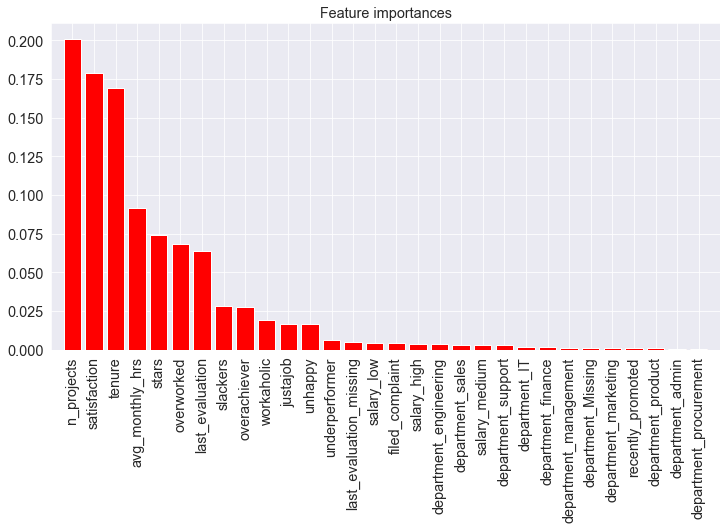

In [113]:
# Print list of feature importances and plot on a bar graph
print("Ranking of feature importance:")

for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, dicts[indices[f]], importances[indices[f]]))

plt.figure(figsize=(12,6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", align="center")
plt.xticks(range(X_train.shape[1]), sorted_feature_importance, rotation='vertical')
plt.xlim([-1, X_train.shape[1]])
plt.show()

#### Comments: the top three most important features were related to workload, happiness and experience, respectively. Two of our engineered features--"stars" and "overworked"--were also relatively strong predictors. 

### Save final model as model_v2.pkl:

In [ ]:
with open('model_v2.pkl', 'wb') as f:
    pickle.dump(fitted_models['rf'].best_estimator_, f)